In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # 2D plotting library
import seaborn as sns  # Python data visualization library based on matplotlib
import warnings  # Typically issued in situations where it is useful to alert the user of some condition in a program
import os
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines import KaplanMeierFitter
from lib.bin_features import bin_feature
from lib.remove_high_corr_feats import remove_highly_correlated_features
from lib.drop_col_with_nan import drop_columns_with_nan
from lib.filter_low_var_feats import filter_low_variance_features
from lib.km_curve_plot import plot_km_curve_for_feature, plot_km_curve_for_features
from lib.remove_duplicated import remove_duplicated_data
from lib.scale_dataframe import scale_dataframes_zscore
warnings.filterwarnings('ignore')  # Ignores all warnings

In [6]:
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'data')

print("RAW MULTIOMICS DATASET")

early_relapse = pd.read_csv(os.path.join(data_path, "early_relapse_complete.csv"), sep=',')  # Reading early relapse data
early_relapse = early_relapse.set_index('MPC')
early_relapse["PFS_I_MONTHS"] = early_relapse["PFS_I_MONTHS"] * 30

dataframe0 = pd.read_csv(os.path.join(data_path, "clinical_data_complete.csv"),
                        sep=',',
                        dtype={'inst': object})  # Reading clinical dataset
dataframe0 = dataframe0.set_index('MPC')
dataframe0.index.name = None
dataframe0 = dataframe0.drop(columns='LAST_FULLOW_UP', axis=1)
print("CLINICAL DATA :", dataframe0.shape)

dataframe1 = pd.read_csv(os.path.join(data_path, "tot_rad_feats_CT.csv"), sep=',')  # Reading CT dataset
dataframe1 = dataframe1.set_index('MPC')
dataframe1.index.name = None
dataframe1 = dataframe1.drop(columns='MPC_EXAM_ID', axis=1)
print("CT :", dataframe1.shape)

dataframe2 = pd.read_csv(os.path.join(data_path, "tot_rad_feats_PET.csv"), sep=',')  # Reading DD dataset
dataframe2 = dataframe2.set_index('MPC')
dataframe2.index.name = None
dataframe2 = dataframe2.drop(columns='MPC_EXAM_ID', axis=1)
print("PET :", dataframe2.shape)


RAW MULTIOMICS DATASET
CLINICAL DATA : (253, 59)
CT : (104, 1218)
PET : (104, 1218)


In [8]:
# Missing data analysis

# Replacing the string "nv" with NaN and single and double with 1 and 2 in pandas dataframe0
dataframe0 = dataframe0.replace("nv", np.nan)
dataframe0 = dataframe0.replace("single", 1)
dataframe0 = dataframe0.replace("double", 2)


threshold = 20  # Set missing data threshold in %

# Calculate the percentage of missing data for each column
missing_percentage = dataframe0.isna().mean().round(4) * 100

# Columns to keep based on the threshold
cols_to_keep = missing_percentage[missing_percentage <= threshold].index.tolist()

# Filter dataframe based on these columns
dataframe0 = dataframe0[cols_to_keep]


CLI: (253, 90)
CT: (104, 1218)
PET: (104, 1218)


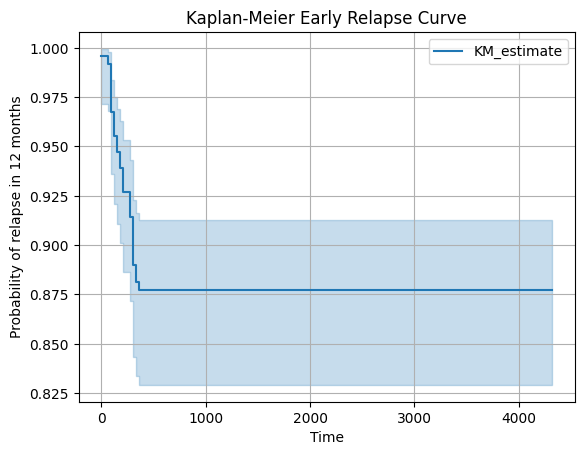

{'CLI_OLD_0_1': 0, 'CLI_Calcio_M_105': 1, 'CLI_PROG_I_EVENT': 2, 'CLI_PFS_I_EVENT': 3, 'CLI_PFS_I_MONTHS': 4, 'CLI_OS_EVENT': 5, 'CLI_OS_MONTH': 6, 'CLI_AGE_40-65y': 7, 'CLI_AGE_>65y': 8, 'CLI_SEX_M': 9, 'CLI_CREATININE_(0.73, 0.92]': 10, 'CLI_CREATININE_(0.92, 1.24]': 11, 'CLI_CREATININE_(1.24, 17.2]': 12, 'CLI_HB_(9.6, 10.85]': 13, 'CLI_HB_(10.85, 12.385]': 14, 'CLI_HB_(12.385, 15.7]': 15, 'CLI_HB_m_105_1': 16, 'CLI_PLT_(177.0, 219.0]': 17, 'CLI_PLT_(219.0, 276.5]': 18, 'CLI_PLT_(276.5, 536.0]': 19, 'CLI_PLT_m_150_1': 20, 'CLI_PC_TOT_(25.0, 45.0]': 21, 'CLI_PC_TOT_(45.0, 80.0]': 22, 'CLI_PC_TOT_(80.0, 100.0]': 23, 'CLI_PC_M_60_1': 24, 'CLI_IG_ISOTYPE_IgA': 25, 'CLI_IG_ISOTYPE_IgA+BJ': 26, 'CLI_IG_ISOTYPE_IgA/BJ': 27, 'CLI_IG_ISOTYPE_IgD': 28, 'CLI_IG_ISOTYPE_IgG': 29, 'CLI_IG_ISOTYPE_IgG/BJ': 30, 'CLI_IG_ISOTYPE_NS': 31, 'CLI_IG_ISOTYPE_ns': 32, 'CLI_LIGHT_CHAIN_Lambda': 33, 'CLI_LIGHT_CHAIN_NS': 34, 'CLI_LIGHT_CHAIN_kappa': 35, 'CLI_LIGHT_CHAIN_lambda': 36, 'CLI_CALCIUM_(9.0, 9.5]':

In [9]:
# BIN FEATURES


dataframe0 = bin_feature(dataframe0, "CREATININE")
dataframe0 = bin_feature(dataframe0, "CALCIUM")
dataframe0 = bin_feature(dataframe0, "PC_TOT")
dataframe0 = bin_feature(dataframe0, "PLT")
dataframe0 = bin_feature(dataframe0, "HB")
# dataframe0 = bin_feature(dataframe0, "EM_SUV_max")
# dataframe0 = bin_feature(dataframe0, "PM_SUVmax")
# dataframe0 = bin_feature(dataframe0, "FL_SUV_max")
# dataframe0 = bin_feature(dataframe0, "cfDNA_tumor_fraction")
# dataframe0 = bin_feature(dataframe0, "gDNA_tumor_fraction")
# dataframe0 = bin_feature(dataframe0, "PCR")

# Defining the bins for age categorization and binning the age labels
age_bins = [0, 39, 65, float('inf')]
age_labels = ['<40y', '40-65y', '>65y']
dataframe0 = bin_feature(dataframe0, 'AGE', bins=age_bins, labels=age_labels)

# one hot encoding
dataframe0 = pd.get_dummies(dataframe0, drop_first=True)

# Adjusting dataframes

dataframes = {
    "CLI": dataframe0,
    "CT": dataframe1,
    "PET": dataframe2
}

# Iterate through dataframes and prepend omics name to column names for easier visualization
for omics_name, df in dataframes.items():
    # Check if the first column already starts with the omics_name
    if not df.columns[0].startswith(f"{omics_name}_"):
        new_columns = [f"{omics_name}_{col}" for col in df.columns]
        df.columns = new_columns
    print(f"{omics_name}: {df.shape}")

kmf1 = KaplanMeierFitter()
kmf1.fit(early_relapse["PFS_I_MONTHS"], early_relapse["early_relapse"])

kmf1.plot_survival_function()
plt.title("Kaplan-Meier Early Relapse Curve")
plt.xlabel("Time")
plt.ylabel("Probability of relapse in 12 months")
plt.grid(True)
plt.show()

column_dict = {col: i for i, col in enumerate(dataframes["CLI"].columns)}
print(column_dict)


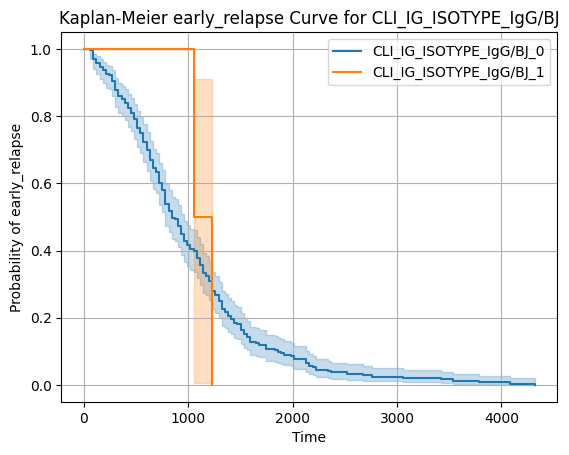

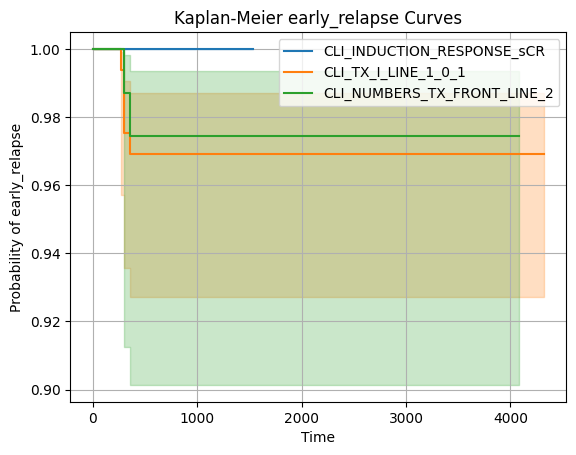

CLI: Original shape (253, 90), after removing duplicates (253, 88)
CT: Original shape (104, 1218), after removing duplicates (104, 1218)
PET: Original shape (104, 1218), after removing duplicates (104, 1218)


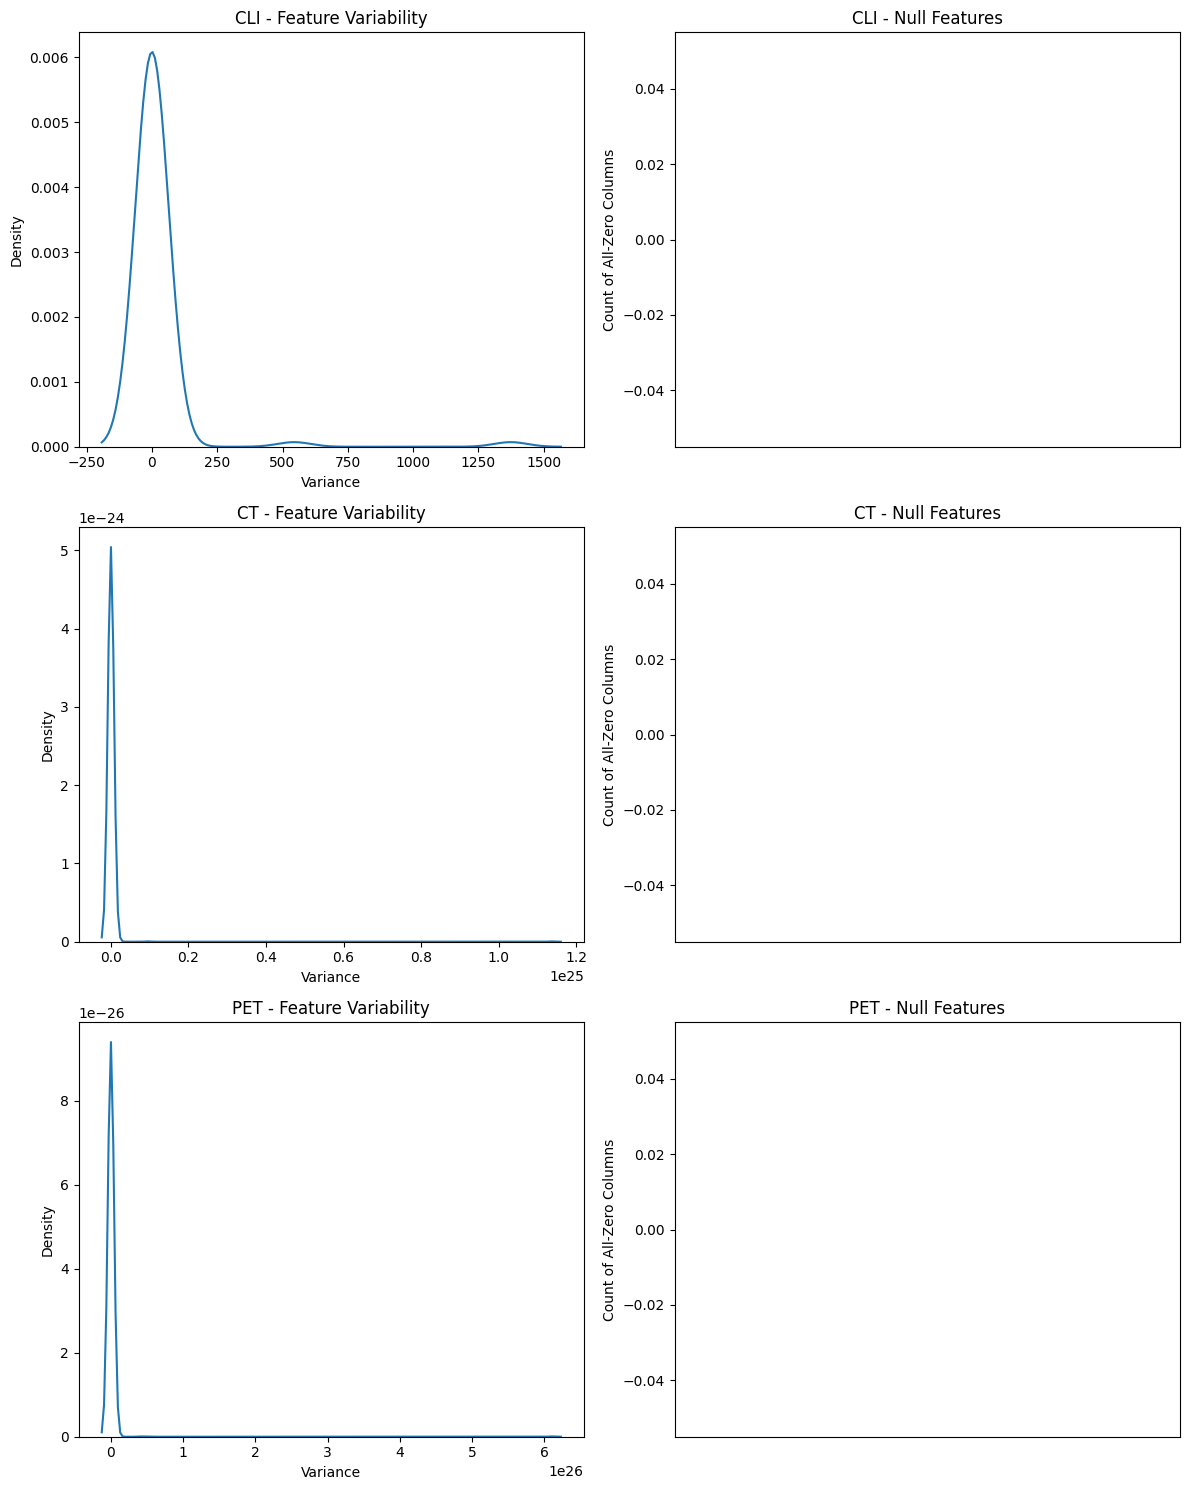

In [10]:
# PLOT KM CURVE WITH ONE FEATURE

# Usage example:
plot_km_curve_for_feature(early_relapse, dataframes["CLI"], 30)


# PLOT KM CURVE WITH MORE FEATURES

# Usage example:
features_to_plot = [45, 46, 47]
plot_km_curve_for_features(early_relapse, dataframes["CLI"], features_to_plot)


# REMOVE DUPLICATED ROWS AND COLUMN

# Call the function with your dataframes_transposed
dataframes, dropped = remove_duplicated_data(dataframes, print_output=True)


# Determine the number of omics DataFrames
num_omics = len(dataframes)

# Create subplots for all omics DataFrames
fig, axes = plt.subplots(num_omics, 2, figsize=(12, 5 * num_omics))

# Iterate through dataframes and create plots for each omics
for i, (omics_name, df3) in enumerate(dataframes.items()):
    # Compute feature variability (variance) for columns
    feature_variability = df3.var(axis=0, skipna=True)

    # Identify columns with all zeros
    null_feature_count = (df3.sum(axis=0) == 0).sum()

    # Create KDE plots for feature variability in the i-th subplot
    sns.kdeplot(feature_variability, ax=axes[i, 0])
    axes[i, 0].set_title(f'{omics_name} - Feature Variability')
    axes[i, 0].set_xlabel('Variance')

    # Plot a bar for the count of null features
    axes[i, 1].bar(1, null_feature_count)  # Only one bar showing count of all-zero columns
    axes[i, 1].set_title(f'{omics_name} - Null Features')
    axes[i, 1].set_ylabel('Count of All-Zero Columns')
    axes[i, 1].set_xticks([])  # Remove x-ticks as they are not relevant here

# Adjust layout and show all plots
plt.tight_layout()
plt.show()


CLI after removing low variance features: (253, 88)
Number of features dropped in CLI: 0
CT after removing low variance features: (104, 897)
Number of features dropped in CT: 321
Features dropped in CT: CT_original_shape_Flatness, CT_original_shape_Sphericity, CT_original_firstorder_Uniformity, CT_original_glcm_JointEnergy, CT_original_glcm_Imc1, CT_original_glcm_Imc2, CT_original_glcm_Idm, CT_original_glcm_Idmn, CT_original_glcm_Id, CT_original_glcm_Idn, CT_original_glcm_InverseVariance, CT_original_glcm_MaximumProbability, CT_original_glrlm_GrayLevelNonUniformityNormalized, CT_original_glrlm_LongRunLowGrayLevelEmphasis, CT_original_glrlm_LowGrayLevelRunEmphasis, CT_original_glrlm_RunLengthNonUniformityNormalized, CT_original_glrlm_RunPercentage, CT_original_glrlm_ShortRunEmphasis, CT_original_glrlm_ShortRunLowGrayLevelEmphasis, CT_original_glszm_GrayLevelNonUniformityNormalized, CT_original_glszm_LowGrayLevelZoneEmphasis, CT_original_glszm_SizeZoneNonUniformityNormalized, CT_original

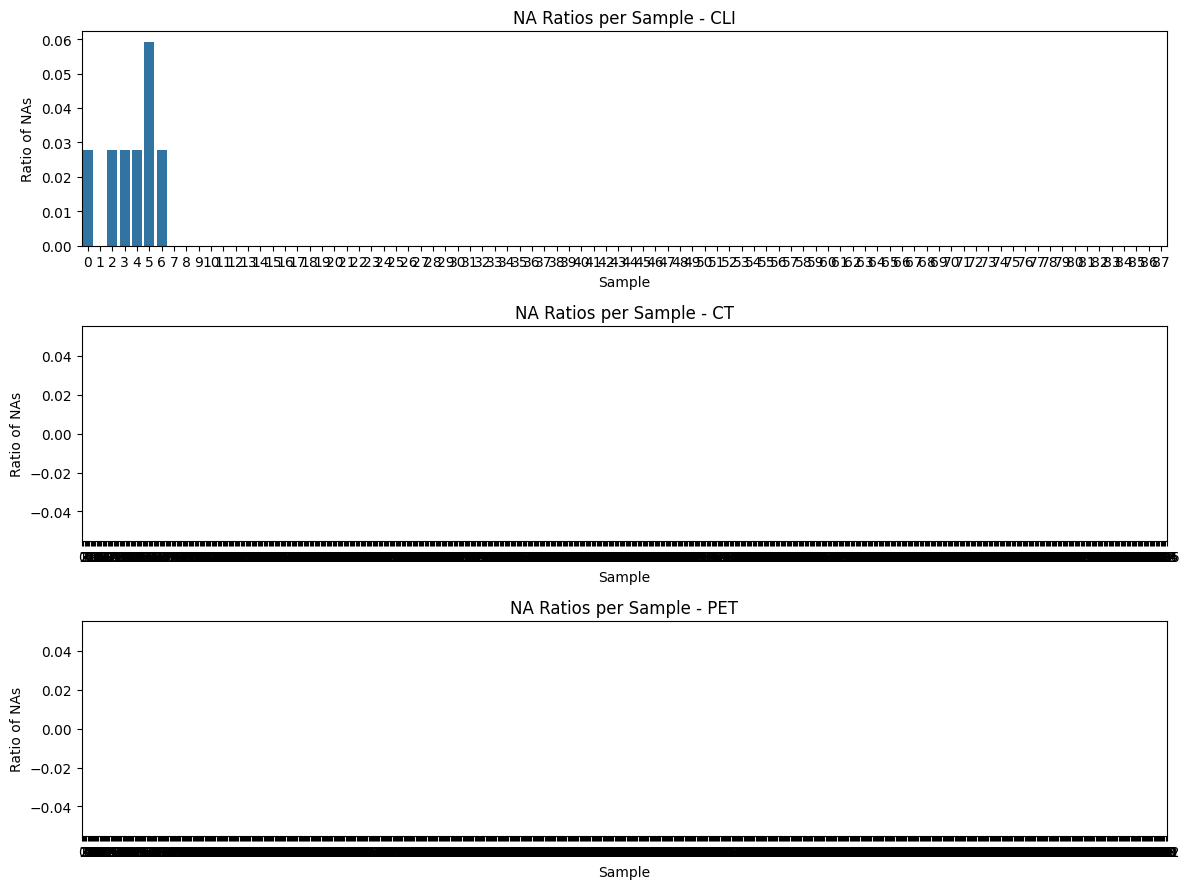

In [11]:
# FILTER LOW VARIANCE FEATURES


# Example usage with different thresholds for each omic type and a default threshold of 0.03
# thresholds = {'CLI': 0.01, 'T2': 0.0001,'T1': 0.0001,'T1Gd': 0.0001,'FLAIR': 0.0001}
# default_threshold = 0.01
dataframes, uninformative_features = filter_low_variance_features(dataframes, default_threshold=0.01, print_output=True)

# Dealing with missing values and highly correlated features

# Calculate NA ratios per sample for each omics
na_ratios_per_sample = {omic: df.isna().sum() / df.shape[0] for omic, df in dataframes.items()}

# Create a plot for each omics
fig, axes = plt.subplots(len(dataframes), figsize=(12, 3 * len(dataframes)))

for i, (omic, na_ratios) in enumerate(na_ratios_per_sample.items()):
    ax = axes[i]
    sns.barplot(
        x=np.arange(0, na_ratios.shape[0]),
        y=na_ratios.values,
        ax=ax
    )
    ax.set_xlabel('Sample')
    ax.set_ylabel('Ratio of NAs')
    ax.set_title(f'NA Ratios per Sample - {omic}')

plt.tight_layout()
plt.show()

In [12]:
# DROP COLUMNS WITH NAN


# Call the function with your dataframes_transposed
dataframes = drop_columns_with_nan(dataframes, print_output=True)

CLI shape after dropping columns with NaN values: (253, 82)
Features removed in CLI: CLI_OLD_0_1, CLI_PROG_I_EVENT, CLI_PFS_I_EVENT, CLI_PFS_I_MONTHS, CLI_OS_EVENT, CLI_OS_MONTH
CT shape after dropping columns with NaN values: (104, 897)
PET shape after dropping columns with NaN values: (104, 993)


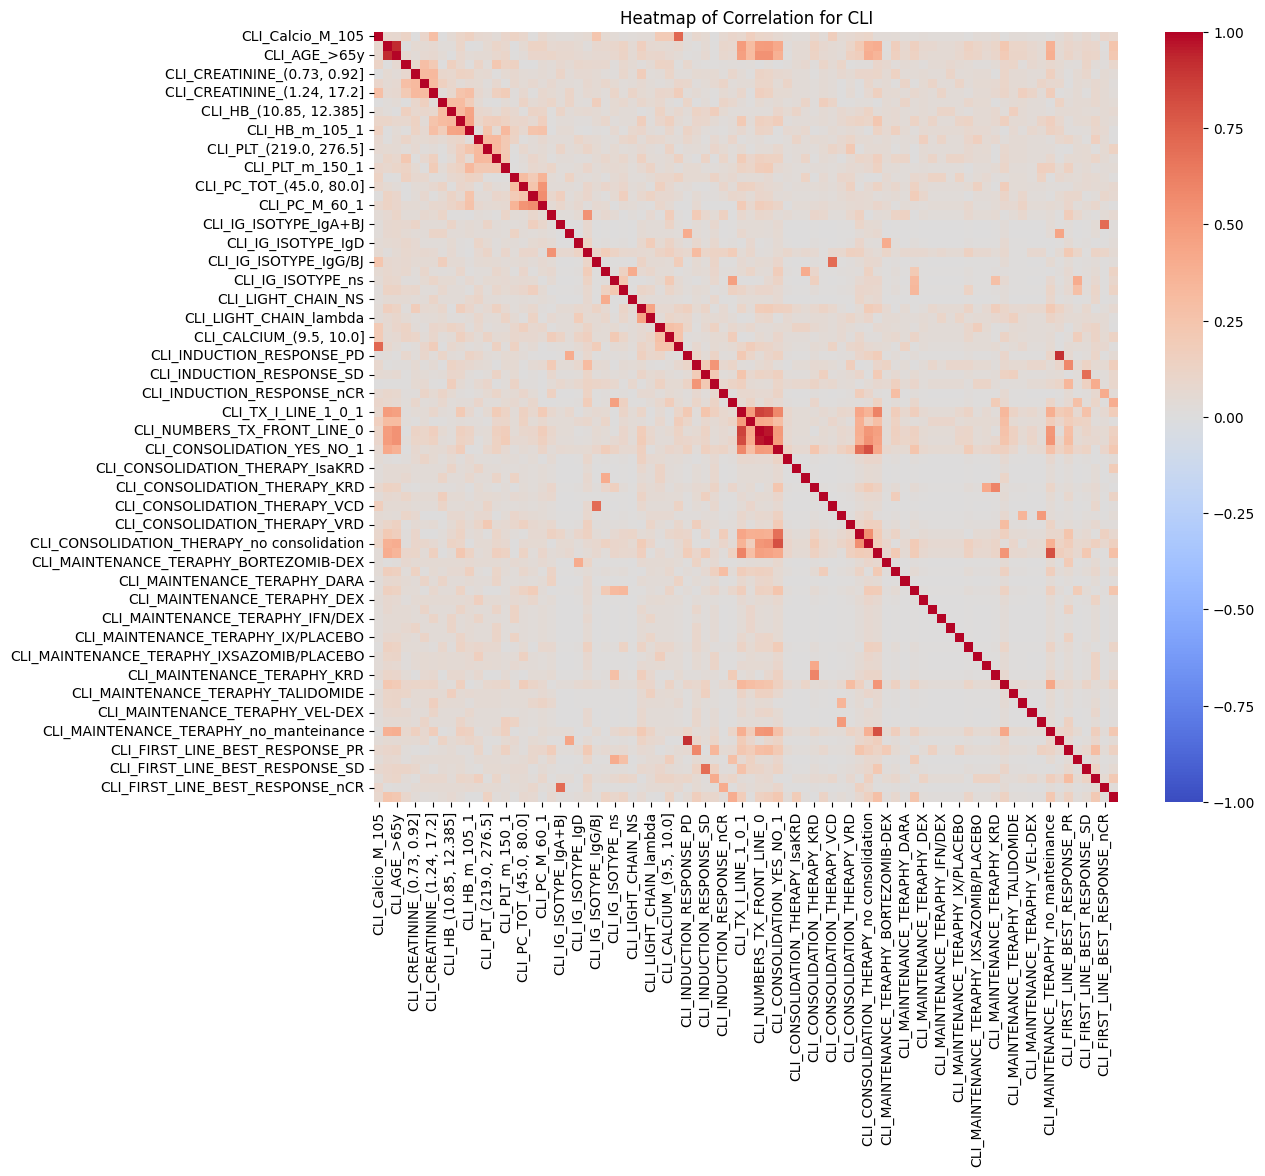

CLI after removing highly correlated features: (253, 79)
Number of features dropped in CLI: 3
Features dropped in CLI: CLI_AGE_>65y, CLI_FRONT_LINE_INDUCTION_CONTINUATIVE_1, CLI_FIRST_LINE_BEST_RESPONSE_PD



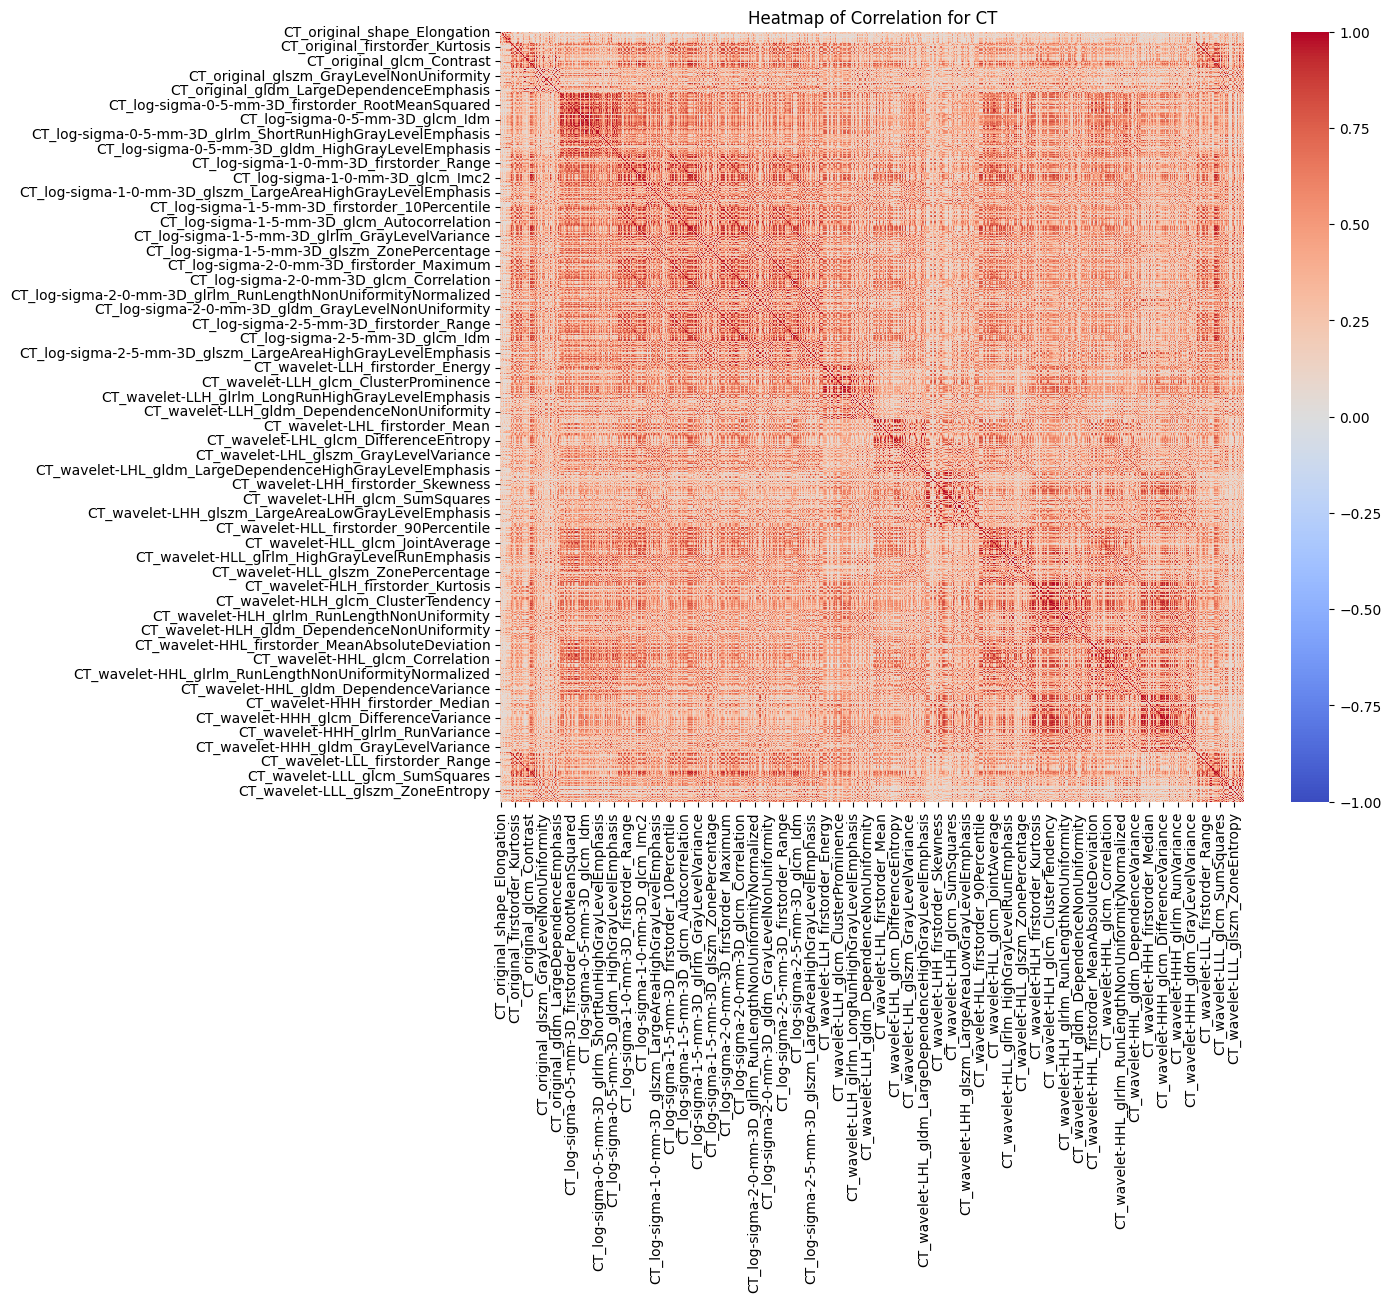

CT after removing highly correlated features: (104, 148)
Number of features dropped in CT: 749
Features dropped in CT: CT_original_shape_MinorAxisLength, CT_original_shape_VoxelVolume, CT_original_firstorder_MeanAbsoluteDeviation, CT_original_firstorder_Mean, CT_original_firstorder_Median, CT_original_firstorder_Range, CT_original_firstorder_RobustMeanAbsoluteDeviation, CT_original_firstorder_RootMeanSquared, CT_original_firstorder_Variance, CT_original_glcm_Autocorrelation, CT_original_glcm_JointAverage, CT_original_glcm_ClusterShade, CT_original_glcm_ClusterTendency, CT_original_glcm_DifferenceAverage, CT_original_glcm_DifferenceEntropy, CT_original_glcm_DifferenceVariance, CT_original_glcm_JointEntropy, CT_original_glcm_SumEntropy, CT_original_glcm_SumSquares, CT_original_glrlm_GrayLevelVariance, CT_original_glrlm_HighGrayLevelRunEmphasis, CT_original_glrlm_LongRunHighGrayLevelEmphasis, CT_original_glrlm_RunEntropy, CT_original_glrlm_RunLengthNonUniformity, CT_original_glrlm_RunVari

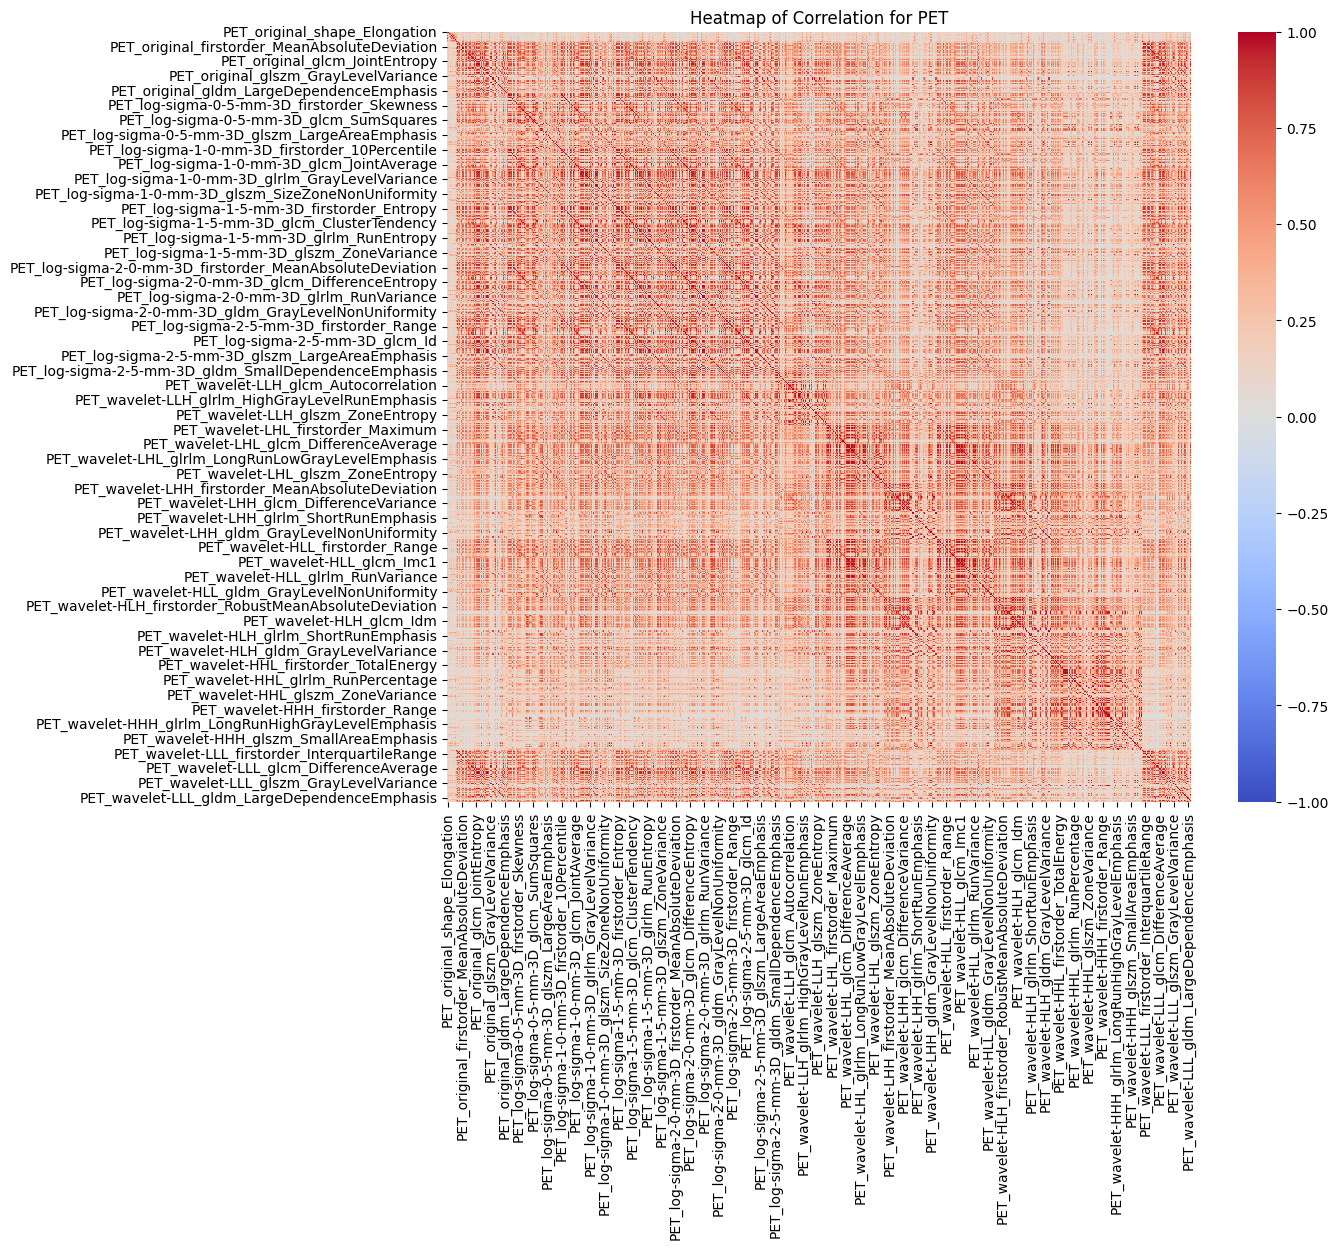

PET after removing highly correlated features: (104, 156)
Number of features dropped in PET: 837
Features dropped in PET: PET_original_shape_MinorAxisLength, PET_original_shape_VoxelVolume, PET_original_firstorder_Entropy, PET_original_firstorder_InterquartileRange, PET_original_firstorder_MeanAbsoluteDeviation, PET_original_firstorder_Mean, PET_original_firstorder_Median, PET_original_firstorder_Range, PET_original_firstorder_RobustMeanAbsoluteDeviation, PET_original_firstorder_Skewness, PET_original_glcm_Autocorrelation, PET_original_glcm_JointAverage, PET_original_glcm_ClusterShade, PET_original_glcm_ClusterTendency, PET_original_glcm_Contrast, PET_original_glcm_DifferenceAverage, PET_original_glcm_DifferenceEntropy, PET_original_glcm_DifferenceVariance, PET_original_glcm_JointEntropy, PET_original_glcm_Idm, PET_original_glcm_Id, PET_original_glcm_InverseVariance, PET_original_glcm_SumEntropy, PET_original_glcm_SumSquares, PET_original_glrlm_GrayLevelVariance, PET_original_glrlm_Hig

In [13]:
# REMOVE HIGHLY CORRELATED FEATURES


dataframes, dropped_corr_features = remove_highly_correlated_features(dataframes,
                                                                    print_output=True,
                                                                    plot_heatmap=True,
                                                                    threshold1=0.90)

# 1. Find Common Patients
# Start with the patients in the survival dataframe
common_patients = set(early_relapse.index)

# Find intersection with patients in each omics dataframe
for omic_name, df in dataframes.items():
    common_patients = common_patients.intersection(df.index)

print("Number of patients present in all dataframes and the survival dataframe:", len(common_patients))

common_patients = list(common_patients)

# 2. Perform Stratified Sampling
# Filter the survival dataframe to only the common patients
filtered_survival_df = early_relapse.loc[common_patients]

# Set the number of patients for the test set
n_test_patients = 20

splitter = StratifiedShuffleSplit(n_splits=1, test_size=n_test_patients, random_state=42)
train_index, test_index = next(splitter.split(filtered_survival_df, filtered_survival_df['early_relapse']))

train_patients = filtered_survival_df.iloc[train_index].index
test_patients = filtered_survival_df.iloc[test_index].index

# 3. Split the Dataframes
dataframes_train = {}
dataframes_test = {}

for omic_name, df in dataframes.items():
    dataframes_train[omic_name] = df.loc[df.index.difference(test_patients)]  # All rows except the test patients
    dataframes_test[omic_name] = df.loc[test_patients]

# Displaying sizes
for omic_name, df_train in dataframes_train.items():
    print(f"{omic_name} Train: {df_train.shape}")
    print(f"{omic_name} Test: {dataframes_test[omic_name].shape}")

# Data standardization

for df, item in dataframes.items():
    print(item.shape)


In [ ]:
# SCALE DATAFRAME

    # SCALE DATAFRAME ZSCORE


    scaled_train_dataframes, scaled_test_dataframes = scale_dataframes_zscore(dataframes_train, dataframes_test)
    dataframes, _ = scale_dataframes_zscore(dataframes)

    for df, item in scaled_train_dataframes.items():
        print(item.shape)
        print(df)
        file_path = data_path + f"/{df}_preprocessed_train.csv"
        item.to_csv(file_path, index=True, index_label="MPC")

    for df, item in scaled_test_dataframes.items():
        print(item.shape)
        print(df)
        file_path = data_path + f"/{df}_preprocessed_test.csv"
        item.to_csv(file_path, index=True, index_label="MPC")

    for df, item in dataframes.items():
        print(item.shape)
        print(df)
        file_path = data_path + f"/{df}_preprocessed.csv"
        item.to_csv(file_path, index=True, index_label="MPC")